In [1]:

import warnings
import numpy as np
# import pandas as pd
import scanpy as sc
import scipy
import featuremap

sc.logging.print_header()
sc.settings.set_figure_params(dpi=120, facecolor='white')

warnings.simplefilter("ignore", category=UserWarning)
warnings.simplefilter("ignore", category=FutureWarning)

/Users/uqyyao4/opt/anaconda3/envs/featmap/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


scanpy==1.9.8 anndata==0.10.5.post1 umap==0.5.4 numpy==1.23.5 scipy==1.12.0 pandas==2.2.1 scikit-learn==1.2.2 statsmodels==0.14.0 igraph==0.11.4 louvain==0.8.0 pynndescent==0.5.11


# FeatureMAP on Pancreatic development data
In this tutorial,  we apply the FeatureMAP tool to a dataset from murine embryonic pancreatic development, specifically on day 15.5 of the embryo's development (E15.5). The original research using this dataset successfully identified various cell clusters and delineated the key developmental trajectories leading to alpha, beta, epsilon, and delta cell states. However, our findings suggest that FeatureMAP provides a more accurate representation of these developmental pathways, especially in precisely tracing the lineage patterns of alpha and beta cells.
1. GEX and GVA visualization
2. Gene variation trajectory and pseudotime
3. Core and transition states, leiden clustering implementation
4. DGV to indentify important genes
5. Gene contribution visualization


## Preprocessing


In [2]:
# Downlowd the data
# Datasets
_datasets = {
    "pancreas": ("https://figshare.com/ndownloader/files/25060877", (2531, 27998)),
}
import os
dataset = 'pancreas'
filepath = f'datasets/{dataset}.h5ad'
# Check if the data is already downloaded
if not os.path.exists(filepath):
    print(f'Downloading {dataset} dataset...')
    # Download the preprocessed pancreas dataset
    adata = sc.read(filename=filepath, backup_url=_datasets[dataset][0])
else:
    adata = sc.read(filepath)

    
# Preprocessing
sc.pp.filter_cells(adata, min_genes=100)
sc.pp.filter_genes(adata, min_cells=3)
# Normalizing to median total counts
sc.pp.normalize_total(adata)
# Logarithmize the data
sc.pp.log1p(adata)
# Highly variable genes
sc.pp.highly_variable_genes(adata, n_top_genes=2000)
adata = adata[:, adata.var.highly_variable]


In [3]:
adata

View of AnnData object with n_obs × n_vars = 2531 × 2000
    obs: 'day', 'proliferation', 'G2M_score', 'S_score', 'phase', 'clusters_coarse', 'clusters', 'clusters_fine', 'louvain_Alpha', 'louvain_Beta', 'palantir_pseudotime', 'n_genes'
    var: 'highly_variable_genes', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'clusters_colors', 'clusters_fine_colors', 'louvain_Alpha_colors', 'louvain_Beta_colors', 'neighbors', 'pca', 'log1p', 'hvg'
    obsm: 'X_pca', 'X_umap'
    layers: 'spliced', 'unspliced'
    obsp: 'connectivities', 'distances'

## FeatureMAP GEX and GVA visualization

We first show UMAP embedding as baseline.

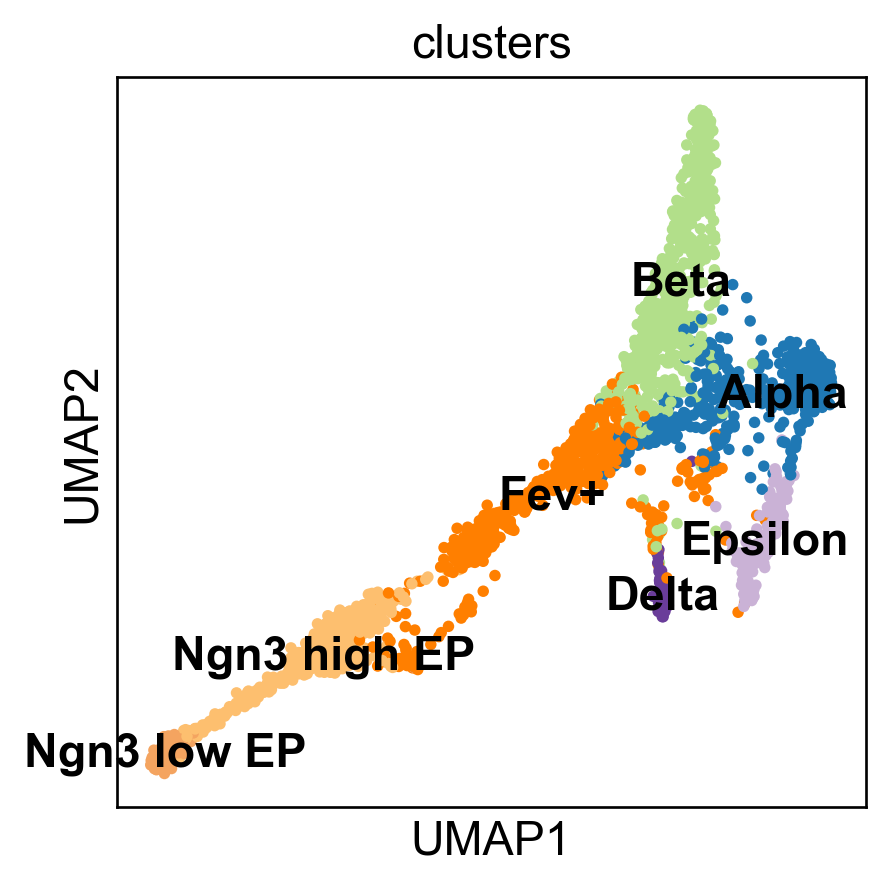

In [4]:
import umap
data = adata.X.copy()
emb_umap = umap.UMAP().fit_transform(data)
adata.obsm['X_umap'] = emb_umap
sc.pl.embedding(adata, basis='umap', color='clusters', legend_loc='on data')

Here is our FeatureMAP-GEX embedding.

In [5]:
data = adata.X.copy()
emb_featuremap = featuremap.FeatureMAP(
                    random_state=42,
                    output_variation=False,
                    output_feat=True,
                    # verbose=True,
                    ).fit(data)

/Users/uqyyao4/opt/anaconda3/envs/featmap/lib/python3.9/site-packages/numba/core/decorators.py:250: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)
/Users/uqyyao4/Library/CloudStorage/OneDrive-TheUniversityofQueensland/project/FeatureMAP-1/featuremap/featuremap_.py:813: RuntimeWarning: invalid value encountered in sqrt
  featuremap_kwds["re_sum"] = np.sqrt(re_sum) # Variance of Gaussian distribution


mu is not added to adata


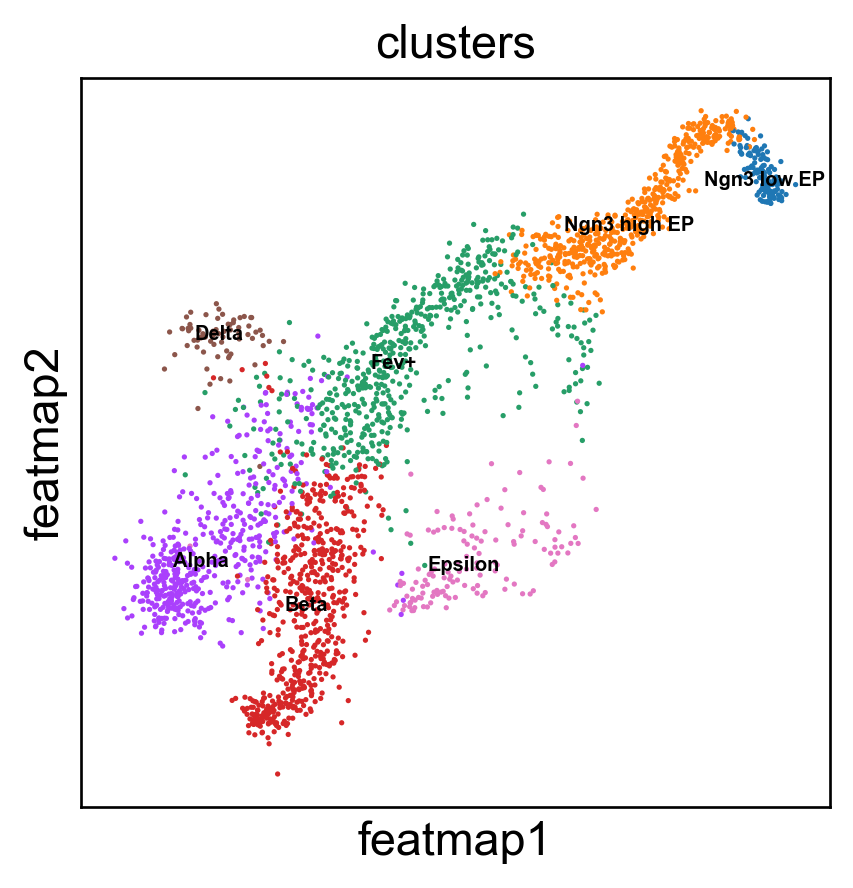

In [6]:
# plot the embedding
from featuremap import features
adata = features.create_adata(X=data, emb_featuremap=emb_featuremap, obs=adata.obs, var=adata.var)
sc.pl.embedding(adata, 'featmap',legend_fontsize=6, s=10, legend_loc='on data', color=['clusters'])

# sc.pl.embedding(adata, 'gauge_v1_emb',legend_fontsize =6, s=10,legend_loc='on data', color=['clusters'])
# sc.pl.embedding(adata, 'gauge_v2_emb',legend_fontsize =6,s=10, legend_loc='on data', color=['clusters'])


In [7]:
adata

AnnData object with n_obs × n_vars = 2531 × 2000
    obs: 'day', 'proliferation', 'G2M_score', 'S_score', 'phase', 'clusters_coarse', 'clusters', 'clusters_fine', 'louvain_Alpha', 'louvain_Beta', 'palantir_pseudotime', 'n_genes'
    var: 'highly_variable_genes', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'clusters_colors'
    obsm: 'X_featmap', '_knn_indices', 'U', 'Singular_value', 'VH', 'vh_smoothed', 'gauge_v1_emb', 'gauge_v2_emb', 'VH_embedding', 'R', 'mu_sum', 're_sum', 're_sum_without_log', 'emb_knn_indices', 'X_embedding'
    varm: 'svd_vh'

### GVA embedding

Diameter is 13
Diameter is 13
Diameter is 13


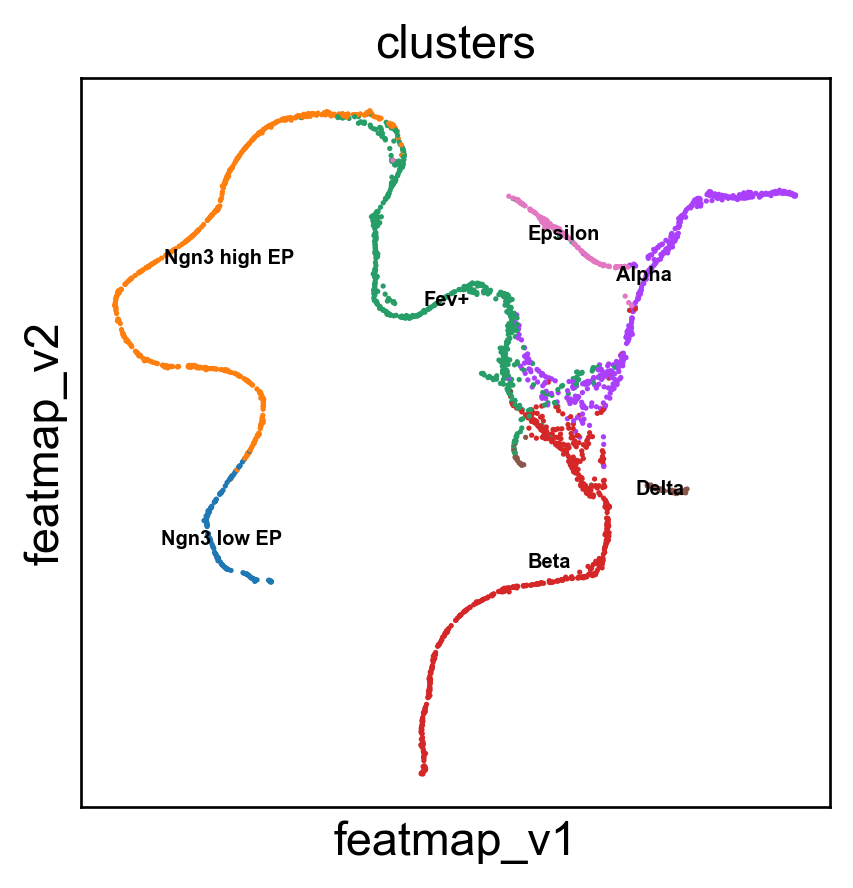

In [8]:
# Variation embedding
import importlib
importlib.reload(featuremap_)
data = adata.X.copy()
emb_featuremap = featuremap_.FeatureMAP(random_state=42,output_variation=True,threshold=0.5, min_dist=0.3).fit(data)

adata.obsm['X_featmap_v'] = emb_featuremap.embedding_
sc.pl.embedding(adata, 'featmap_v',legend_fontsize=6, s=10, legend_loc='on data', color=['clusters'])

adata.obsm['variation_pc'] = emb_featuremap._featuremap_kwds['variation_pc']


3D embedding

In [9]:
data = adata.X.copy()
from featuremap import featuremap_
emb_featuremap_3d = featuremap_.FeatureMAP(n_components=3,random_state=42,output_variation=True,).fit_transform(data)

adata.obsm['X_featmap_v_3d'] = emb_featuremap_3d


Diameter is 13
Diameter is 13
Diameter is 13


In [10]:



from featuremap import features
import importlib
importlib.reload(features)

features.featuremap_var_3d(emb_featuremap_3d, color=adata.obs['clusters'])

Pseudotime.

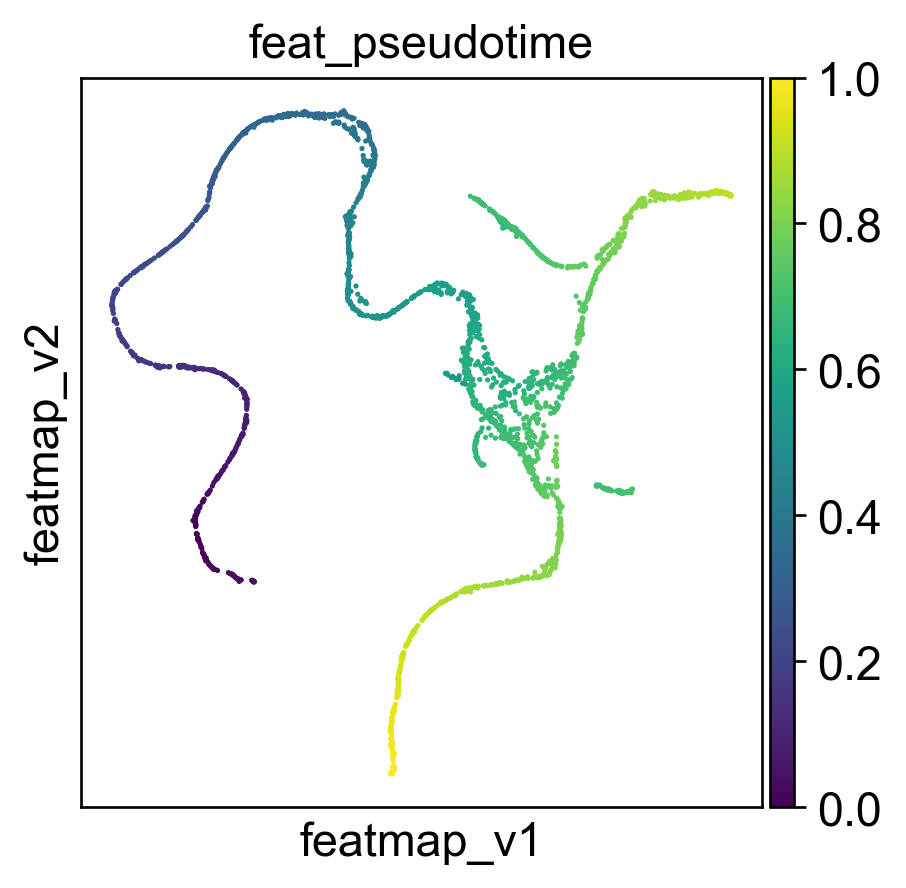

In [11]:
# FeatureMAP pseudo-time
from featuremap import features
import importlib
importlib.reload(features)

# Starting point index
# Randomly select a starting point from cluster "Ng3 low EP"
start_point_index = np.where(adata.obs['clusters'] == 'Ngn3 low EP')[0][0]
features.pseudotime_mst(adata, random_state=42, start_point_index=start_point_index)

sc.pl.embedding(adata, 'featmap_v',legend_fontsize=10, s=10, color=['feat_pseudotime'])

## Core and transition states

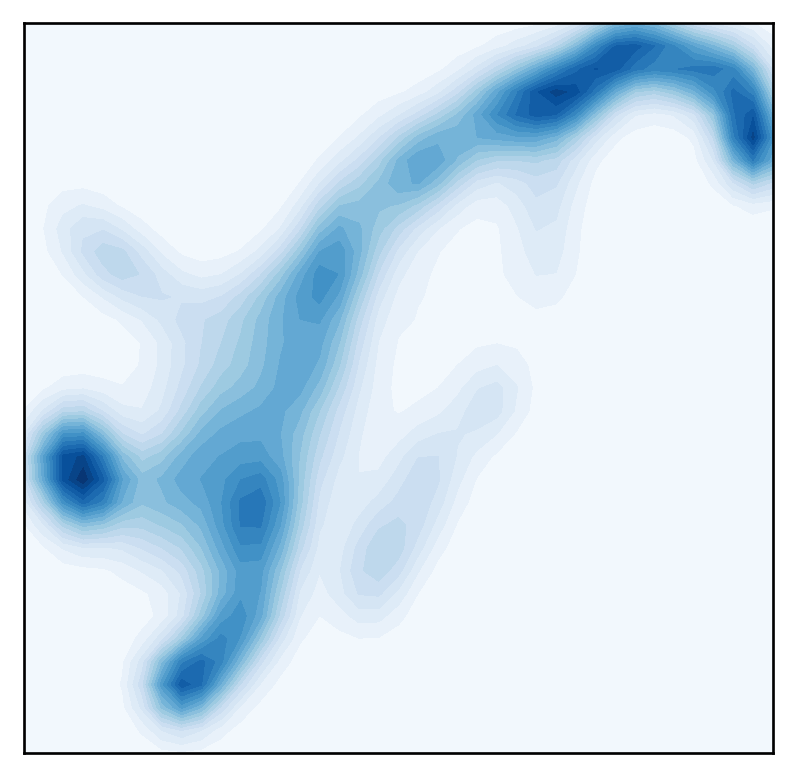

<Figure size 480x480 with 0 Axes>

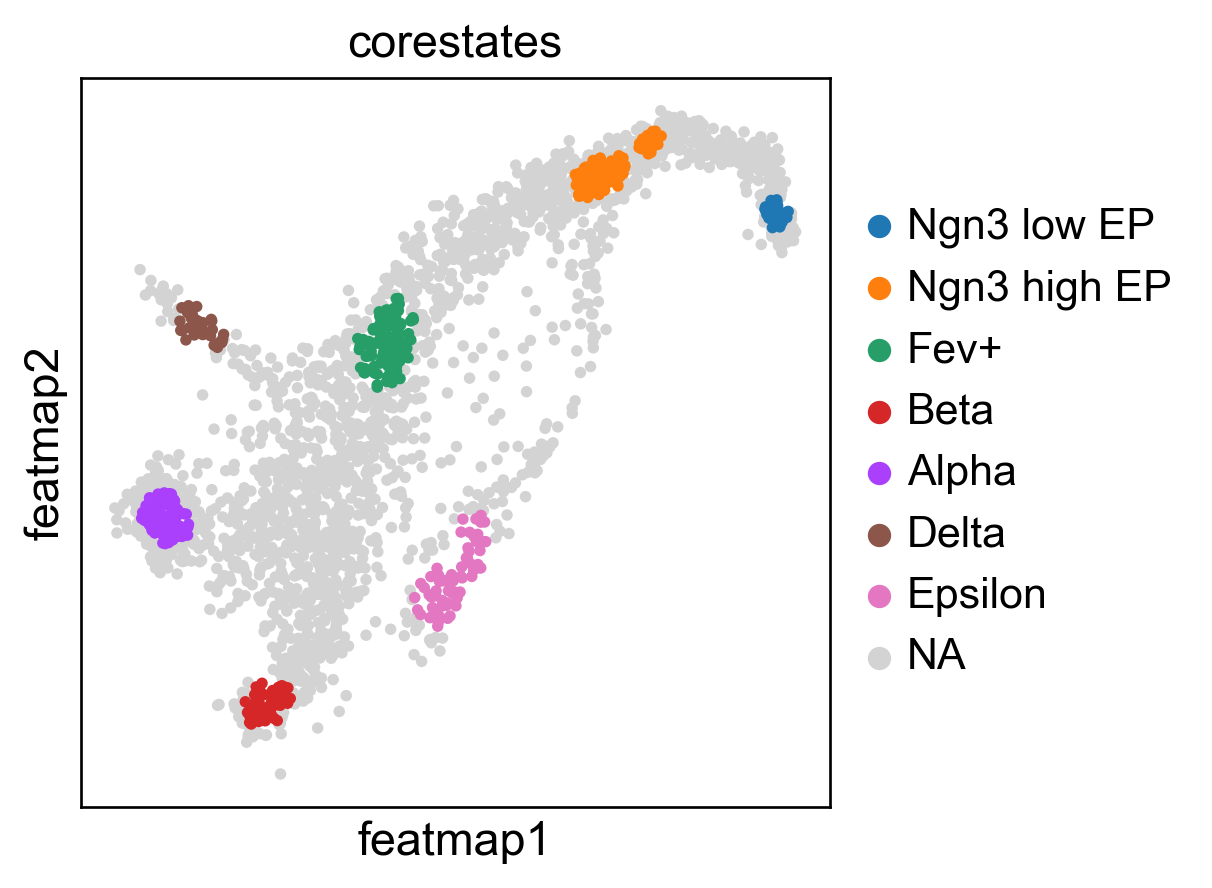

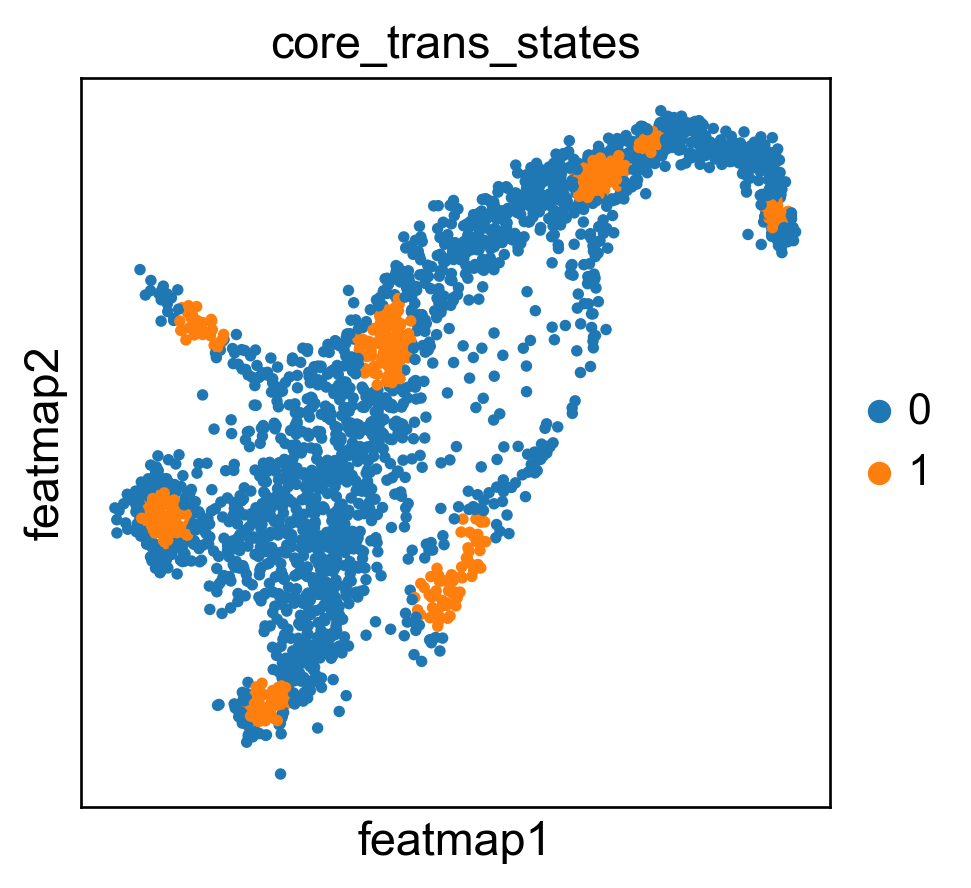

In [12]:
# Contour plot to show the density

from featuremap import core_transition_state
import importlib
importlib.reload(core_transition_state)

# Plot the density 
core_transition_state.plot_density(adata)

# Compute core-states based on clusters
core_transition_state.core_transition_state(adata)

Project core and transition states to GVA embedding.

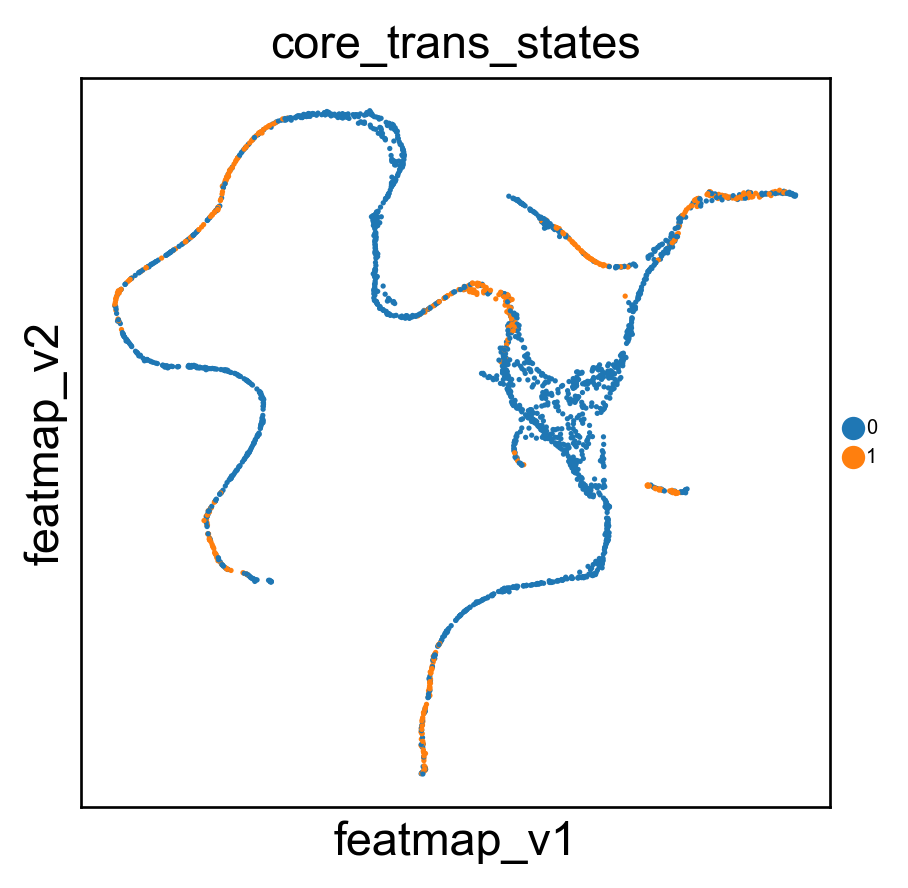

In [13]:
# plot core/transition states on variation embedding
sc.pl.embedding(adata, 'featmap_v',legend_fontsize =6, s=10, color=['core_trans_states'])

In [14]:
adata

AnnData object with n_obs × n_vars = 2531 × 2000
    obs: 'day', 'proliferation', 'G2M_score', 'S_score', 'phase', 'clusters_coarse', 'clusters', 'clusters_fine', 'louvain_Alpha', 'louvain_Beta', 'palantir_pseudotime', 'n_genes', 'feat_pseudotime', 'density', 'density_separate_cluster', 'corestates', 'corestates_largest', 'corestates_binary', 'corestates_points', 'core_trans_states'
    var: 'highly_variable_genes', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'clusters_colors', 'corestates_colors', 'core_trans_states_colors'
    obsm: 'X_featmap', '_knn_indices', 'U', 'Singular_value', 'VH', 'vh_smoothed', 'gauge_v1_emb', 'gauge_v2_emb', 'VH_embedding', 'R', 'mu_sum', 're_sum', 're_sum_without_log', 'emb_knn_indices', 'X_embedding', 'X_featmap_v', 'variation_pc', 'X_featmap_v_3d'
    varm: 'svd_vh'

In [15]:
emb_featuremap_3d = adata.obsm['X_featmap_v_3d']
features.featuremap_var_3d(emb_featuremap_3d, color=adata.obs['core_trans_states'], marker_size=1)

In [16]:
adata

AnnData object with n_obs × n_vars = 2531 × 2000
    obs: 'day', 'proliferation', 'G2M_score', 'S_score', 'phase', 'clusters_coarse', 'clusters', 'clusters_fine', 'louvain_Alpha', 'louvain_Beta', 'palantir_pseudotime', 'n_genes', 'feat_pseudotime', 'density', 'density_separate_cluster', 'corestates', 'corestates_largest', 'corestates_binary', 'corestates_points', 'core_trans_states'
    var: 'highly_variable_genes', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'clusters_colors', 'corestates_colors', 'core_trans_states_colors'
    obsm: 'X_featmap', '_knn_indices', 'U', 'Singular_value', 'VH', 'vh_smoothed', 'gauge_v1_emb', 'gauge_v2_emb', 'VH_embedding', 'R', 'mu_sum', 're_sum', 're_sum_without_log', 'emb_knn_indices', 'X_embedding', 'X_featmap_v', 'variation_pc', 'X_featmap_v_3d'
    varm: 'svd_vh'

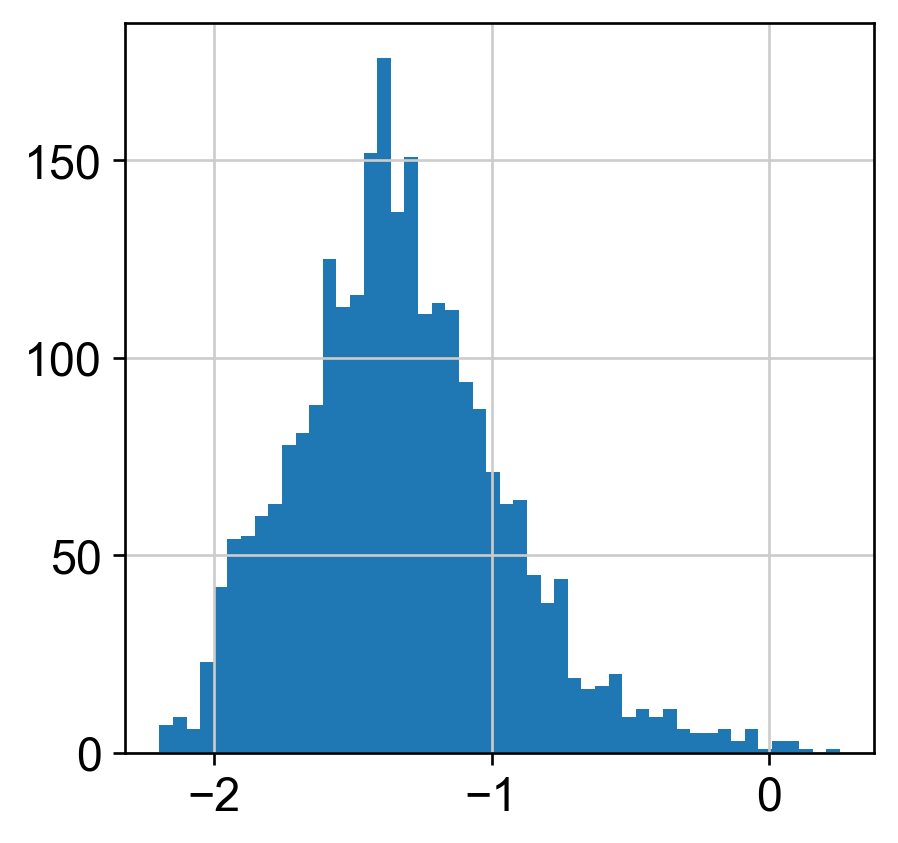

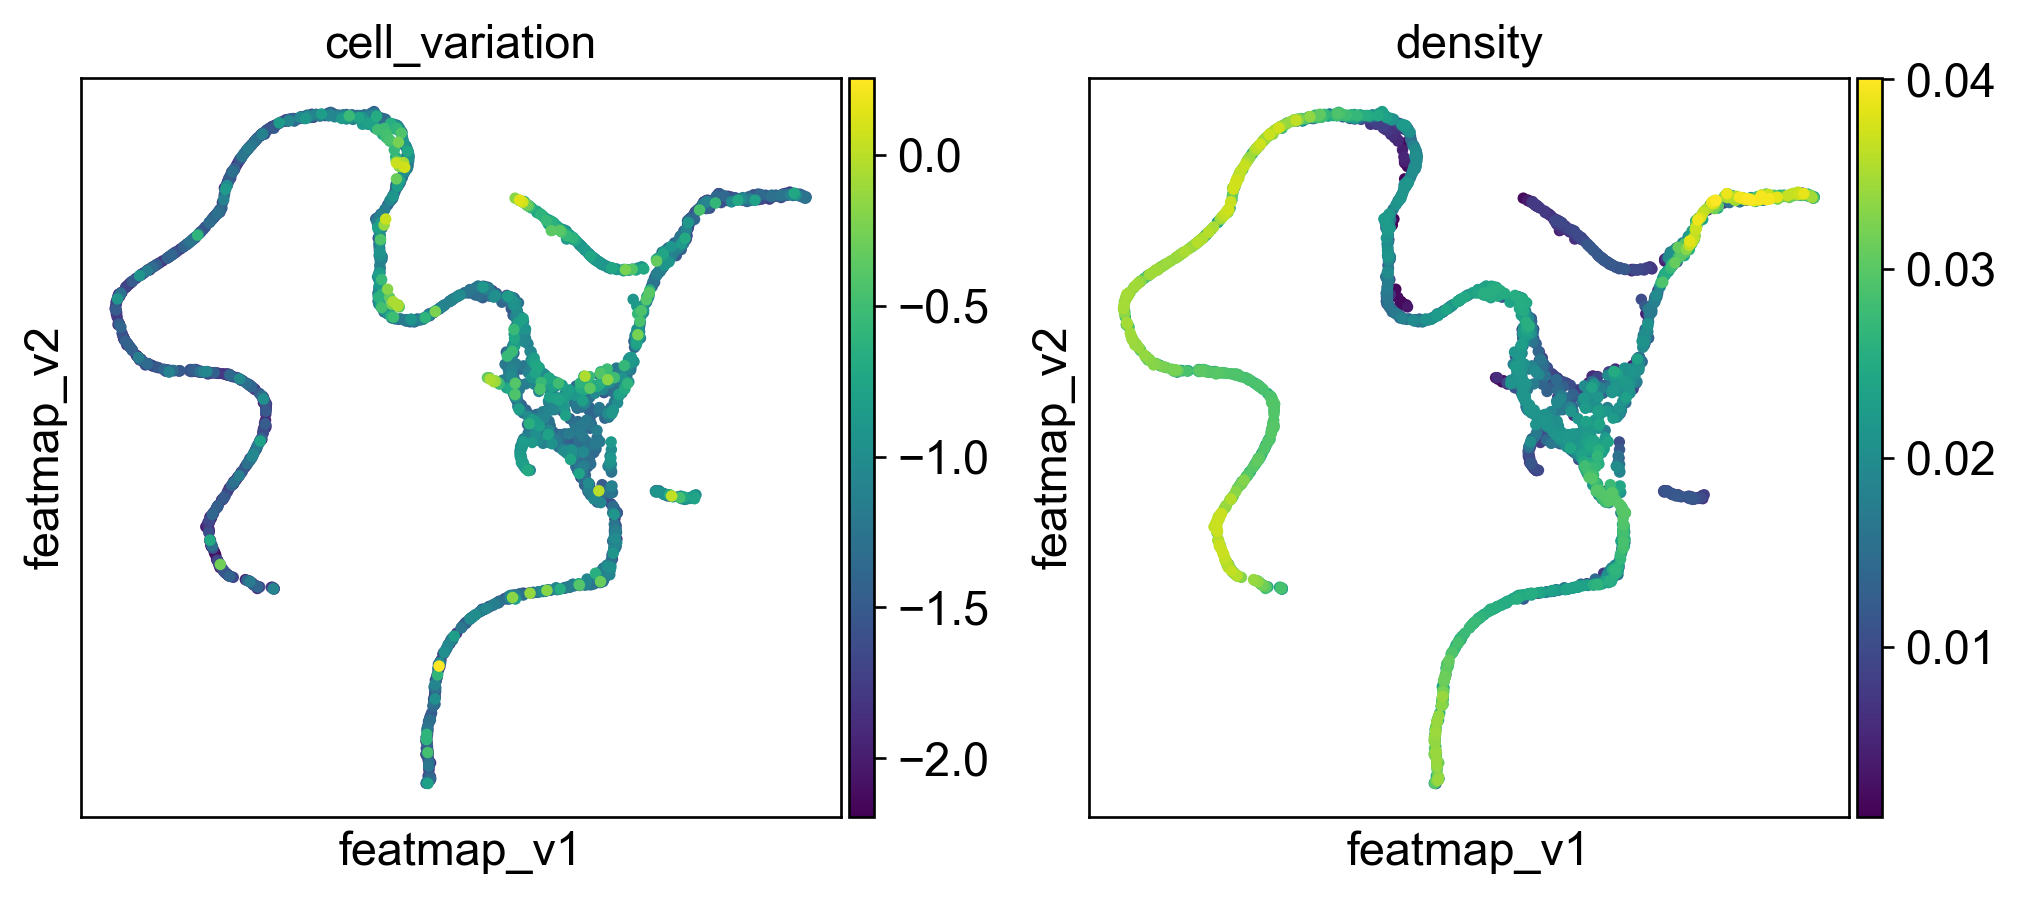

In [17]:
"""
Cell variation
"""
#######################################################
# use singular values to represent the variation
############################################################
# singular_val = emb_featuremap._featuremap_kwds['Singular_value']
# singular_val = emb_featuremap._featuremap_kwds['R']
singular_val = adata.obsm['re_sum_without_log']

# norm of the top k singular values
k=10
singular_val_norm = np.linalg.norm(singular_val[:,:k], axis=1)
singular_val_norm = np.log(singular_val_norm)
# plt.hist(singular_val_norm, bins=50)
import matplotlib.pyplot as plt
plt.hist(singular_val_norm, bins=50)

adata.obs['cell_variation'] = singular_val_norm
sc.pl.embedding(adata, 'featmap_v', legend_loc='on data' , legend_fontsize=10,color=['cell_variation', 'density',])

In [19]:
adata

AnnData object with n_obs × n_vars = 2531 × 2000
    obs: 'day', 'proliferation', 'G2M_score', 'S_score', 'phase', 'clusters_coarse', 'clusters', 'clusters_fine', 'louvain_Alpha', 'louvain_Beta', 'palantir_pseudotime', 'n_genes', 'feat_pseudotime', 'density', 'density_separate_cluster', 'corestates', 'corestates_largest', 'corestates_binary', 'corestates_points', 'core_trans_states', 'cell_variation'
    var: 'highly_variable_genes', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'clusters_colors', 'corestates_colors', 'core_trans_states_colors'
    obsm: 'X_featmap', '_knn_indices', 'U', 'Singular_value', 'VH', 'vh_smoothed', 'gauge_v1_emb', 'gauge_v2_emb', 'VH_embedding', 'R', 'mu_sum', 're_sum', 're_sum_without_log', 'emb_knn_indices', 'X_embedding', 'X_featmap_v', 'variation_pc', 'X_featmap_v_3d'
    varm: 'svd_vh'

  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############           

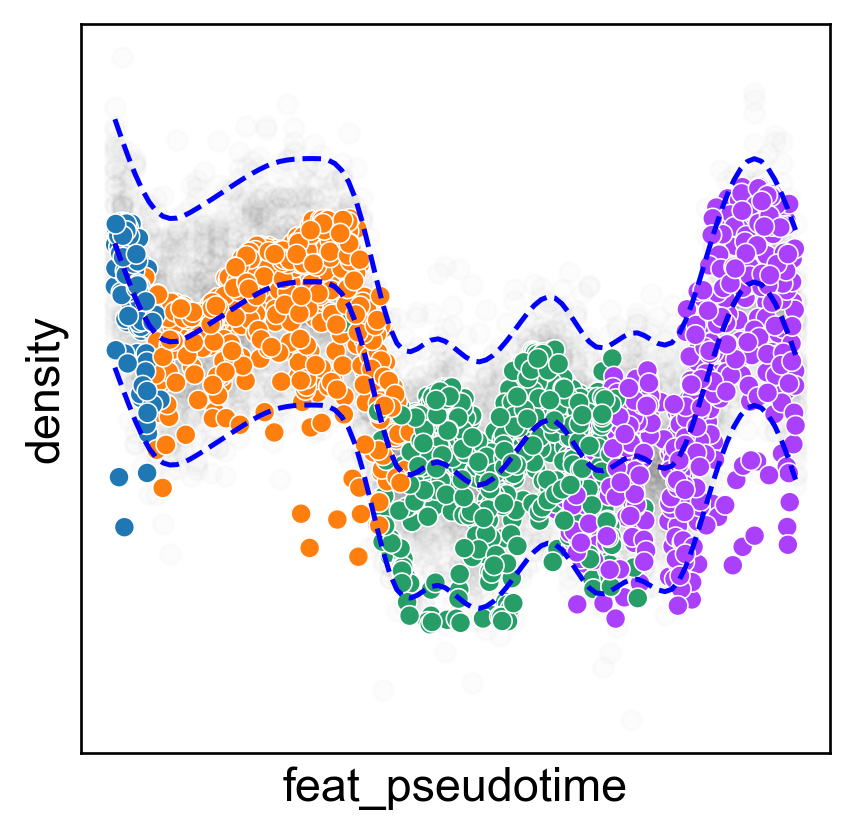

In [33]:
import importlib
importlib.reload(core_transition_state)

#%%
# Filter cells based on clusters

selected_clusters = ['Ngn3 low EP', 'Ngn3 high EP', 'Fev+', 'Alpha']
# selected_clusters = ['Ngn3 low EP', 'Ngn3 high EP', 'Fev+', 'Beta']
# selected_clusters = ['Fev+', 'Beta']
# selected_clusters = ['Fev+', 'Alpha']


# selected_clusters = ['Exh-Int', 'Exh-KLR']
# selected_clusters = ['Fev+', 'Alpha']
filtered_data = adata.obs[adata.obs['clusters'].isin(selected_clusters)]
# downsample the data to 350 cells
# filtered_data = filtered_data.sample(n=350, random_state=42)
# Filter data with density larger than 0.02
# filtered_data = filtered_data[filtered_data['density'] > 0.03]
#%%
# Denstiy vs pseudotime
# pseudotime_list = ['feat_pseudotime','dpt_pseudotime', 'palantir_pseudotime', 'slingshot_pseudotime', 'monocle2_pseudotime', 
                #    'monocle3_pseudotime',  'scFate_pseudotime', 'via_pseudotime']
# for pseudotime in pseudotime_list:
core_transition_state.plot_density_pseudotime(filtered_data, pseudotime='feat_pseudotime', density='density', clusters='clusters')

Leiden clustering to refine the core and transition states.

In [21]:
import anndata as ad
adata_var = ad.AnnData(X=adata.obsm['variation_pc'], obs=adata.obs)
adata_var.obsm['X_featmap_v'] = adata.obsm['X_featmap_v']
adata_var.obs['clusters'] = adata.obs['clusters']

# leiiden clustering on variation embedding
sc.pp.pca(adata_var)
sc.pp.neighbors(adata_var, n_neighbors=5,)
sc.tl.leiden(adata_var, resolution=0.5)

adata.obs['leiden_v'] = adata_var.obs['leiden']


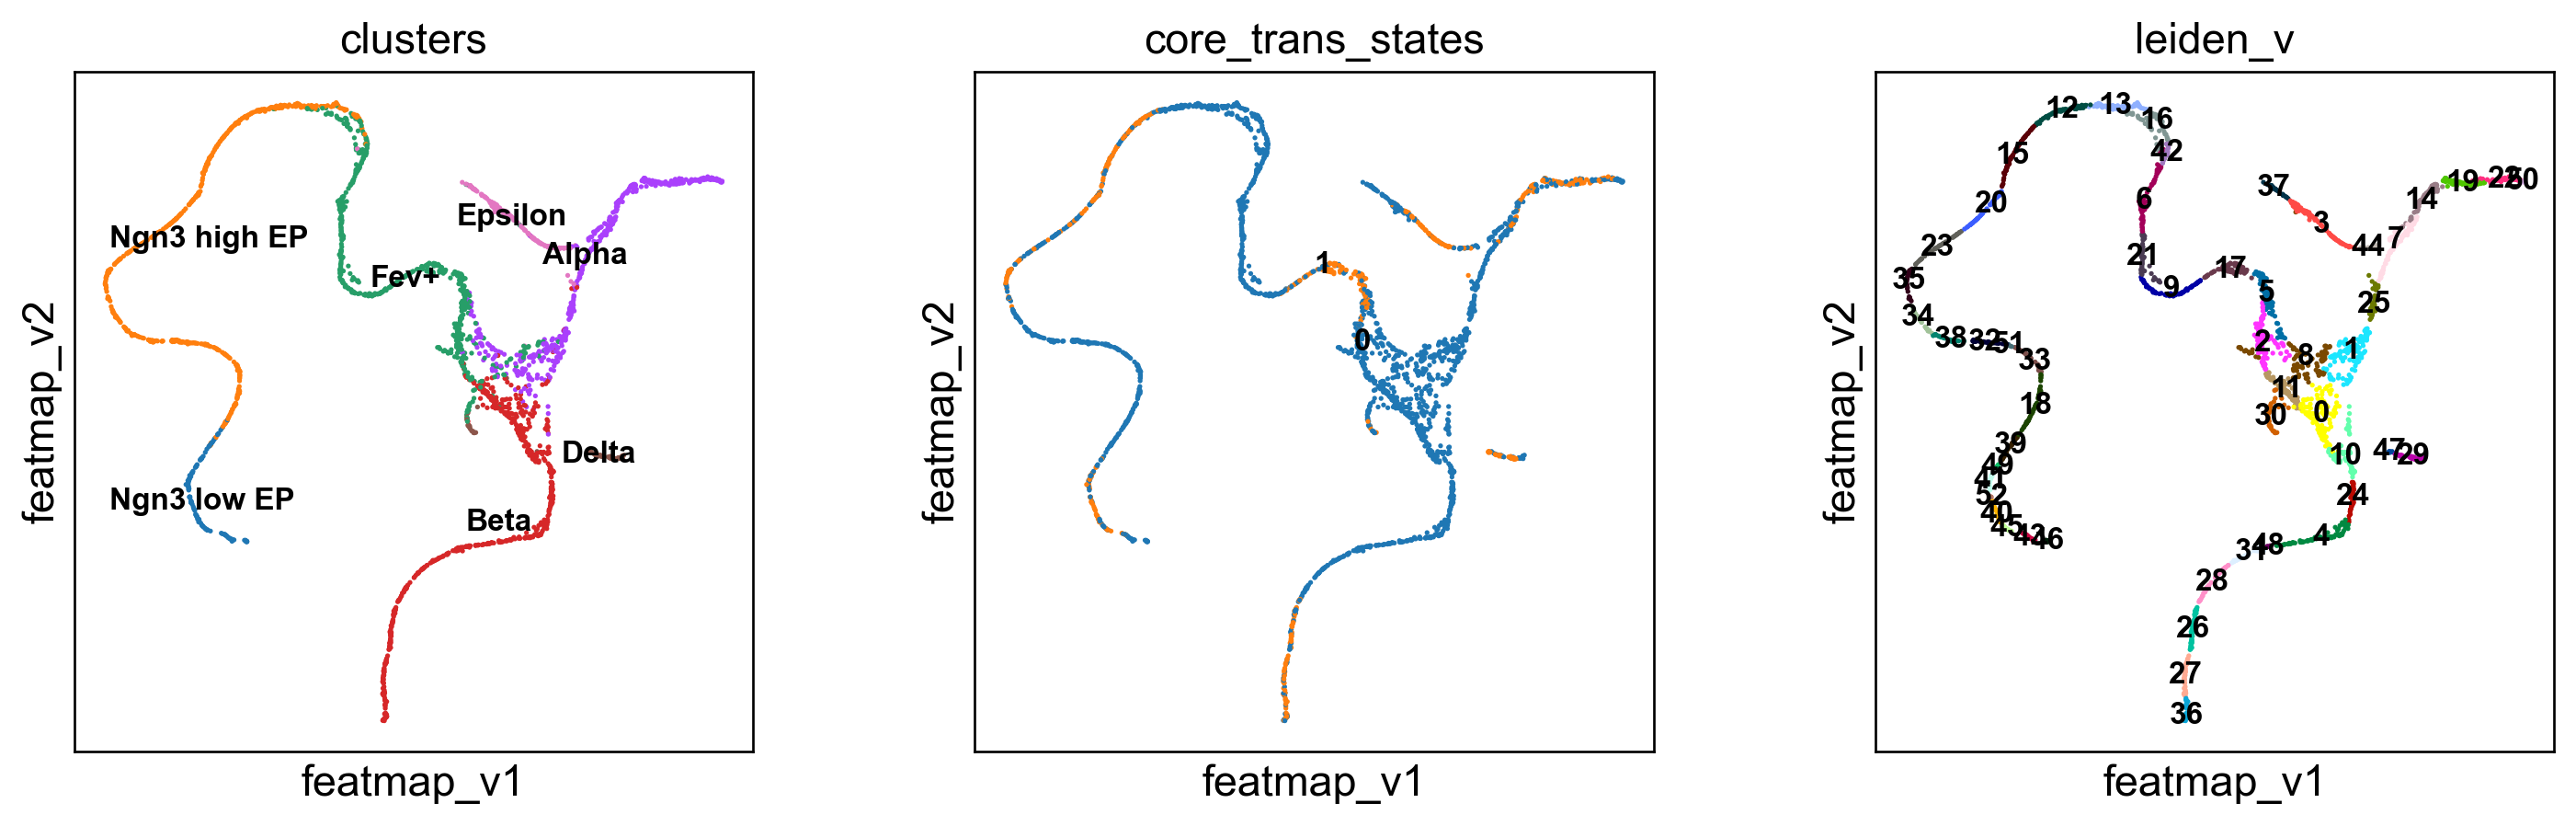

In [22]:
#  plot the density
sc.settings.set_figure_params(dpi=120)

sc.pl.embedding(adata, 'featmap_v',legend_fontsize=10, s=10, legend_loc='on data', 
                color=['clusters','core_trans_states', 'leiden_v'])

In [23]:
import importlib
importlib.reload(features)

# features.featuremap_var_3d(emb_featuremap_3d, color=adata.obs['clusters'], marker_size=3)
features.featuremap_var_3d(emb_featuremap_3d, color=adata.obs['leiden_v'], symbol=adata.obs['clusters'], marker_size=1)

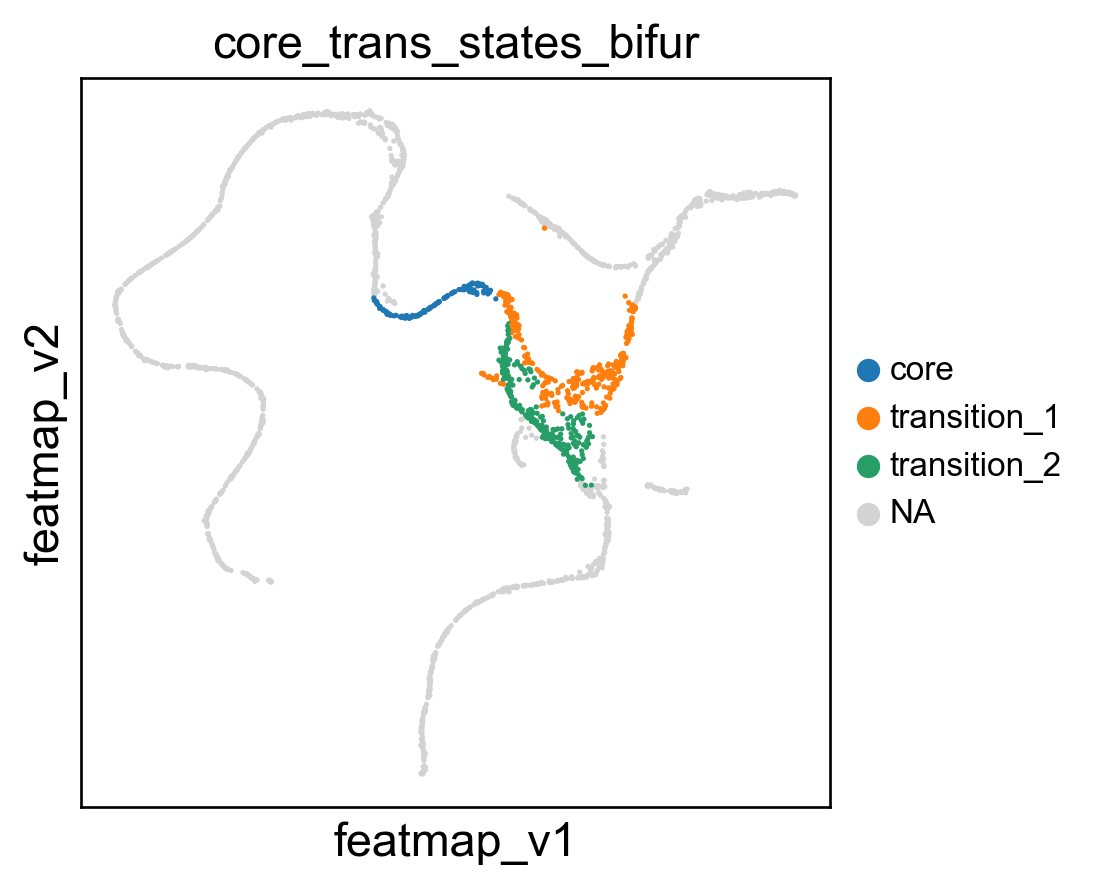

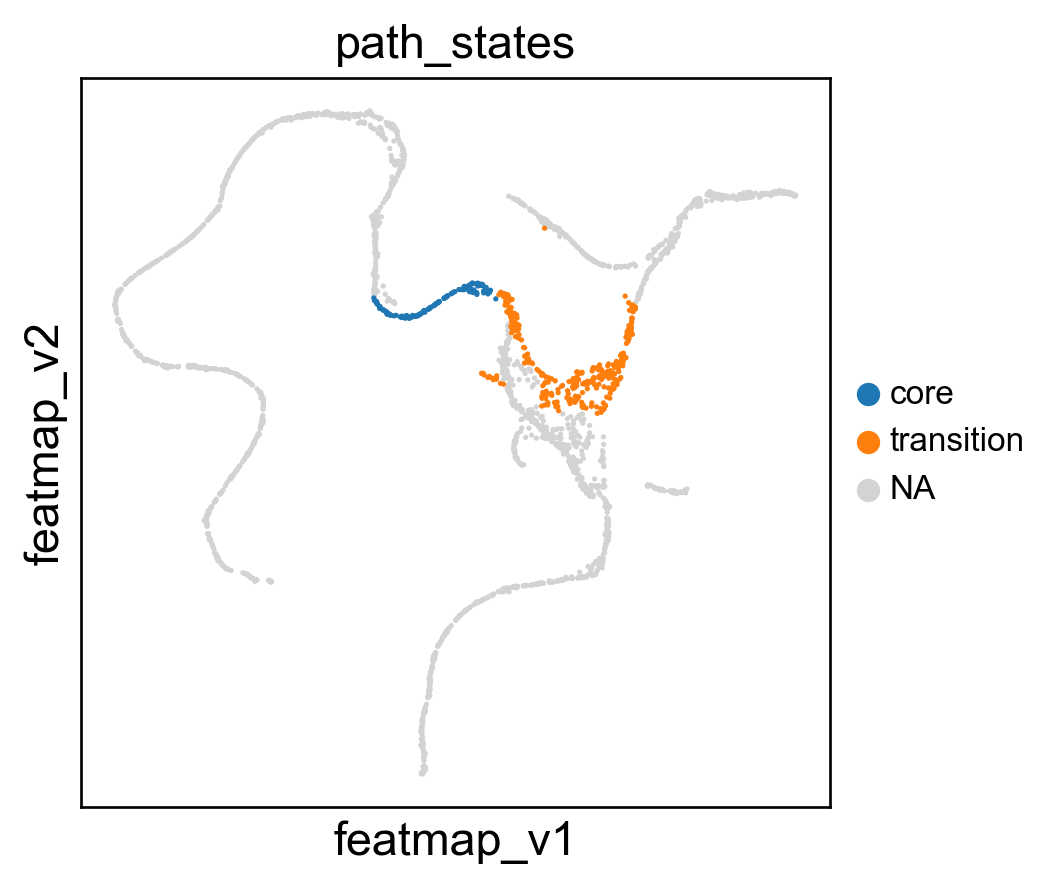

In [24]:

# During the bifurcation, select the core states and transition states by leiiden clustering
core_states = [9,17,]
transition_states_1 = [5, 8,1,25]
transition_states_2 = [2,11,0]


from featuremap import core_transition_state
import importlib
importlib.reload(core_transition_state)

core_transition_state.bifurcation_plot(adata, core_states, transition_states_1, transition_states_2)
core_transition_state.path_plot(adata, core_states, transition_states_1)




T-test p-value for core states and transition states_1: 3.547302209904033e-05


Text(0.5, 1.0, 'T-test p-value is 3.547e-05')

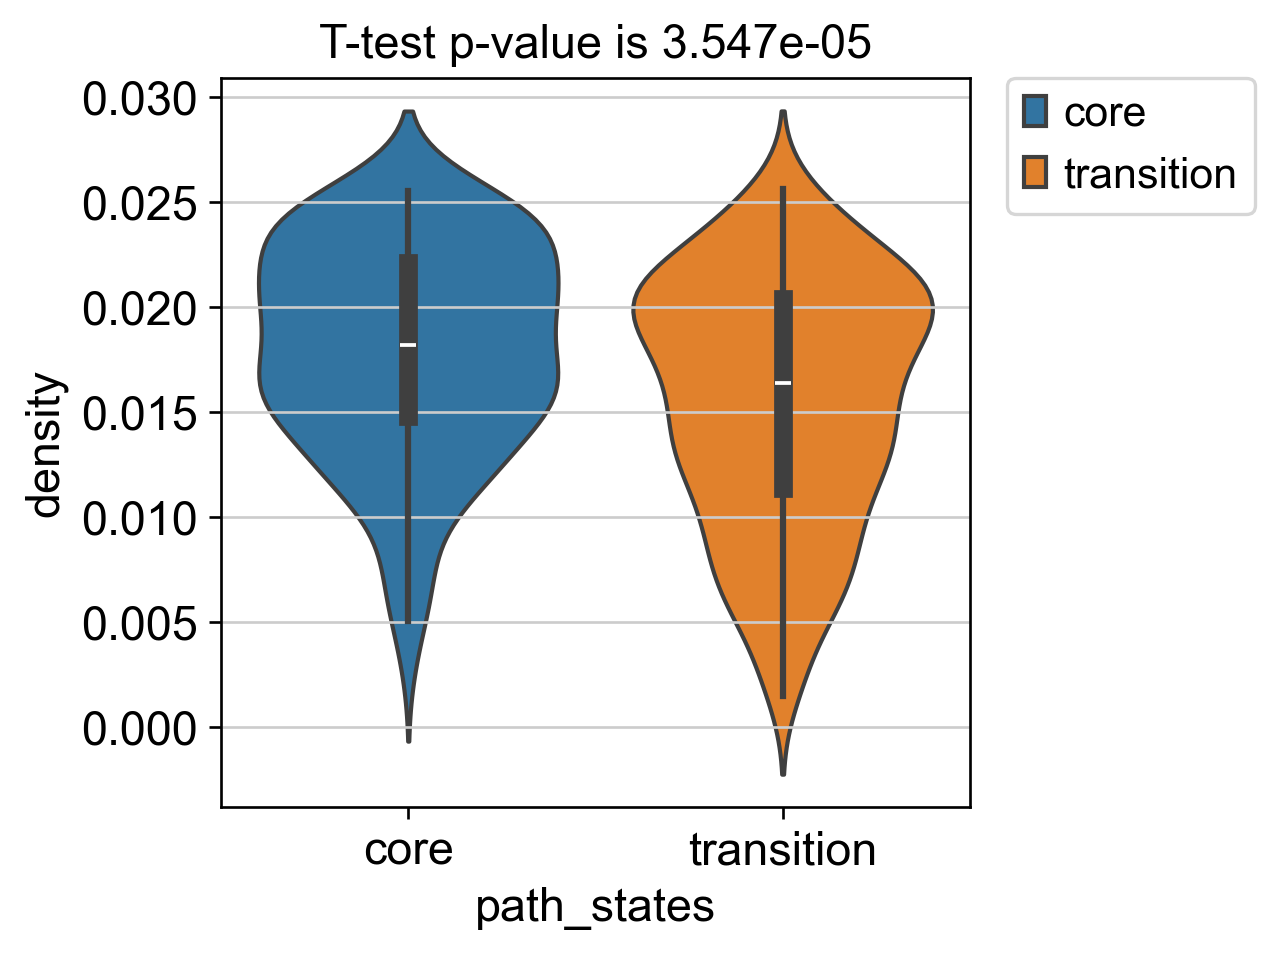

In [25]:
# violin plot to show the density of core states and transition states
from scipy import stats
# t-test for the density of core states and transition states_1
p_val = stats.ttest_ind(adata.obs[adata.obs['path_states']=='core']['density'],
                adata.obs[adata.obs['path_states']=='transition']['density'])[1]
print(f'T-test p-value for core states and transition states_1: {p_val}')

# plot the p_value in the violin plot
import seaborn as sns
import matplotlib.pyplot as plt
sns.violinplot(x ='path_states', y ='density', data = adata.obs, hue='path_states')
# legend outside of the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# p_value with exponential base 10

plt.title( 'T-test p-value is ' + "{0:.{1}e}".format(p_val, 3))


Differential Gene Variation Analysis

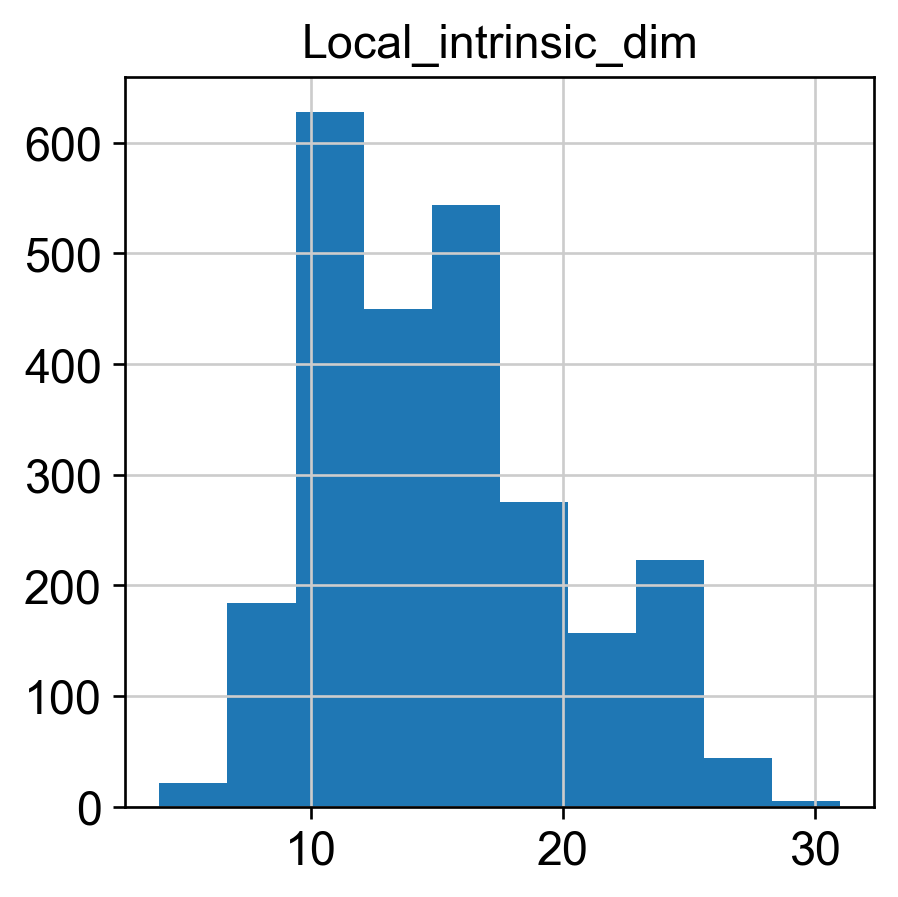

k is 14
Start matrix multiplication
Finish matrix multiplication in 4.837829113006592
Finish norm calculation in 0.2568540573120117


<Figure size 480x480 with 0 Axes>

In [26]:
importlib.reload(featuremap_)
from featuremap.features import feature_variation, feature_variation_embedding
feature_variation(adata, threshold=0.9)

adata_var = features.variation_feature_pp(adata)

adata.layers['variation_feature_processed'] = adata_var.layers['var_filter'].copy()


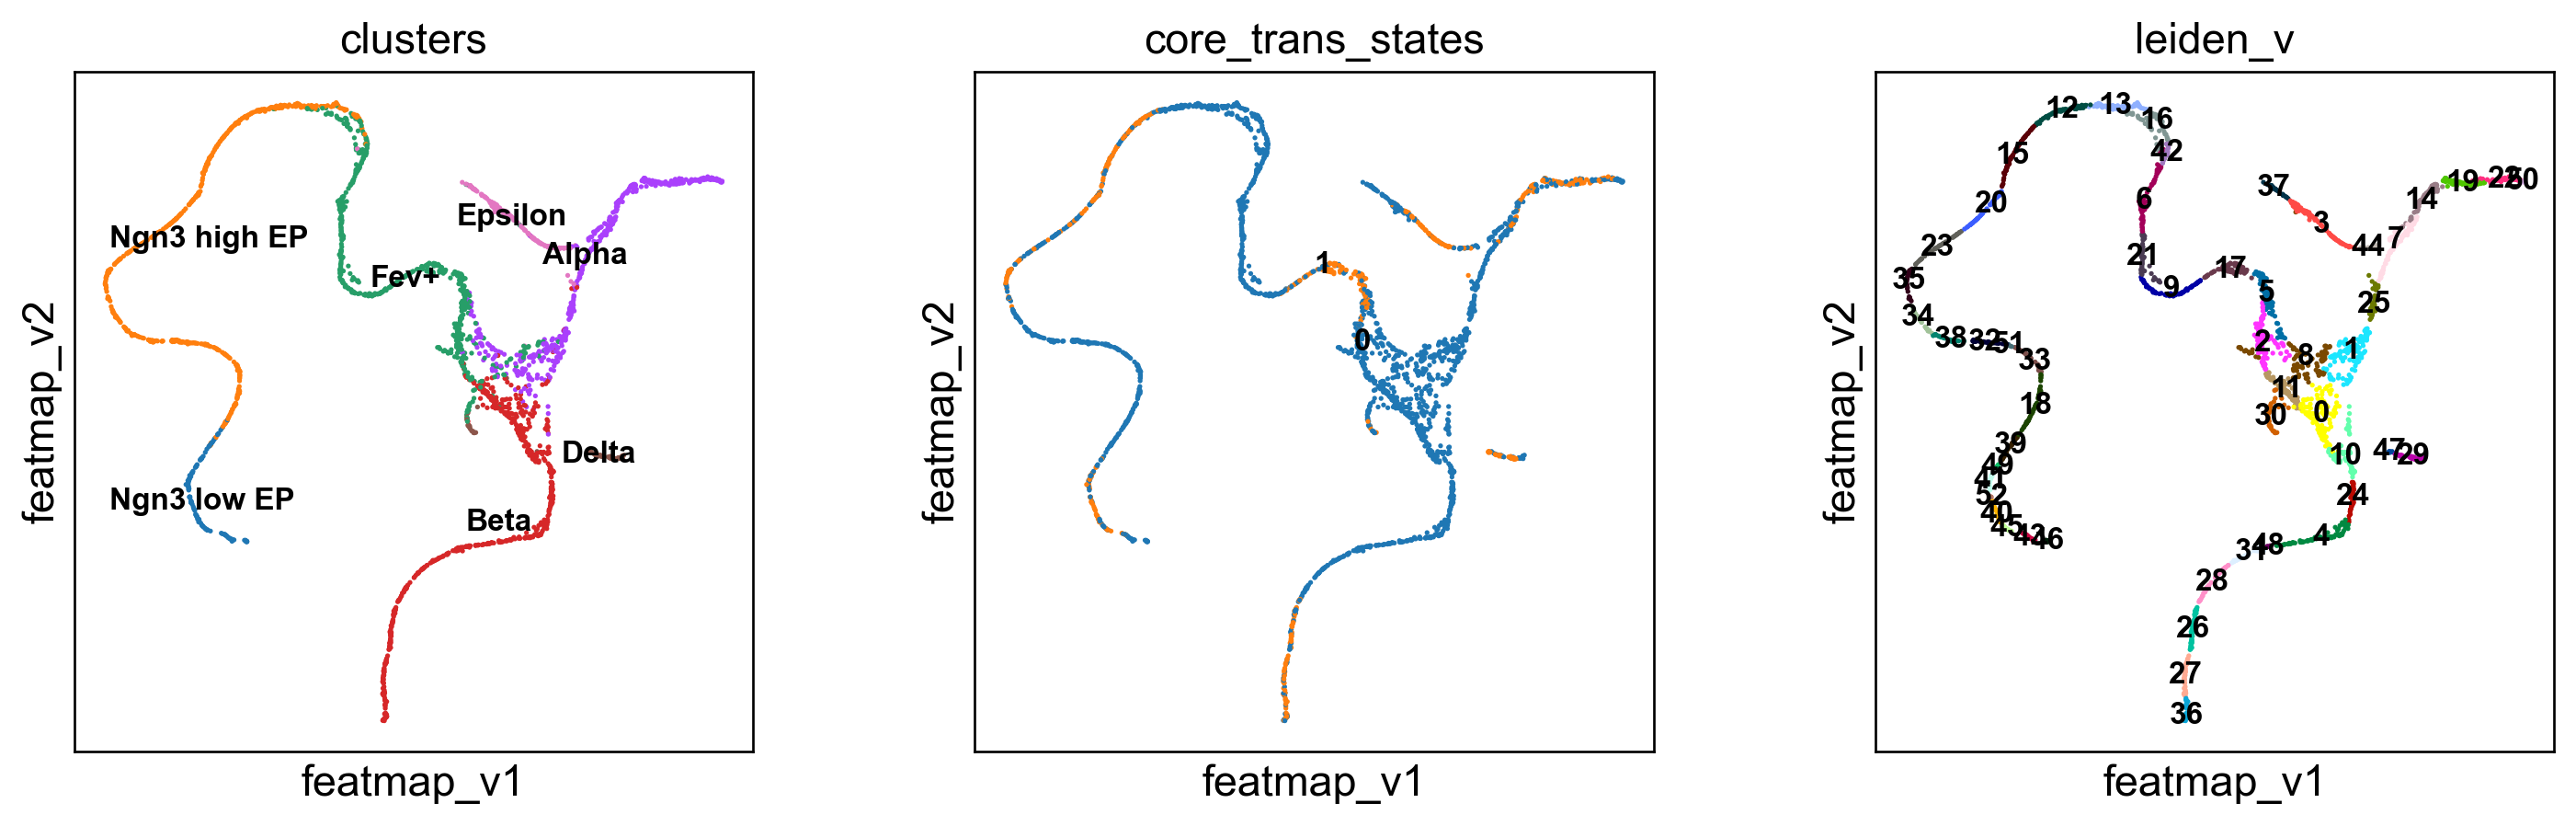

In [27]:
sc.pl.embedding(adata, 'featmap_v',legend_fontsize=10, s=10, legend_loc='on data', 
                color=['clusters','core_trans_states', 'leiden_v'])

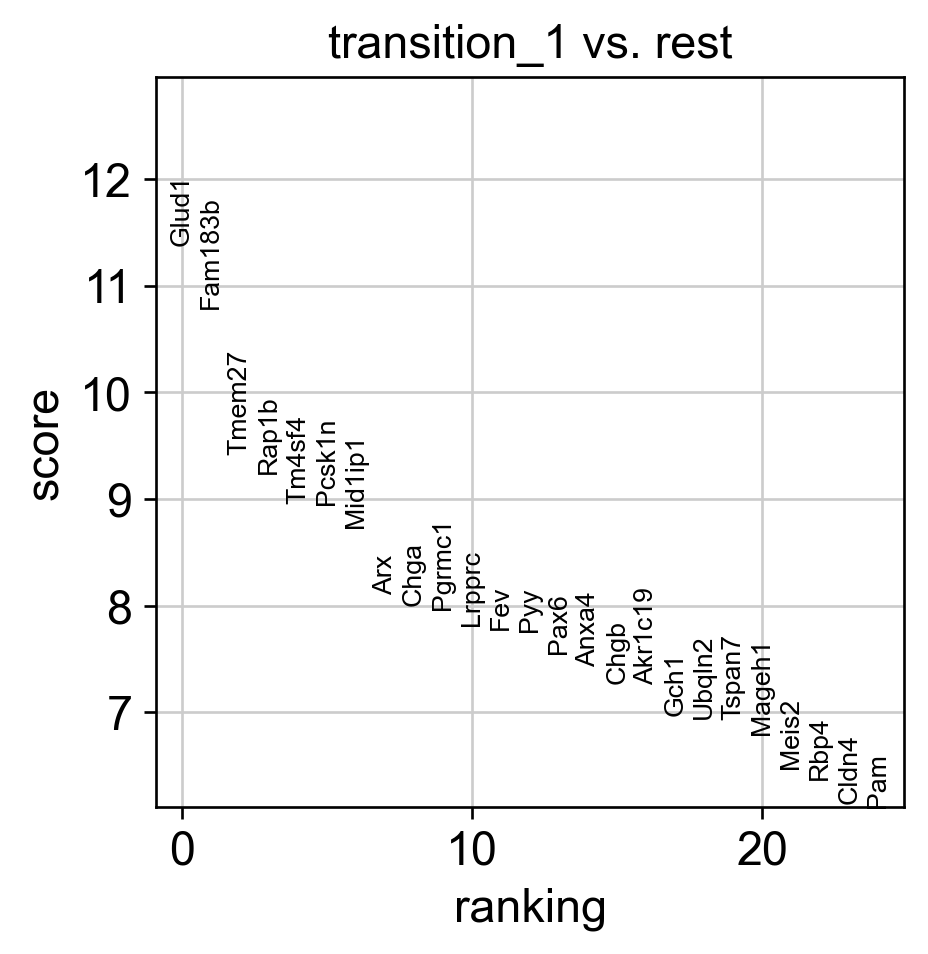

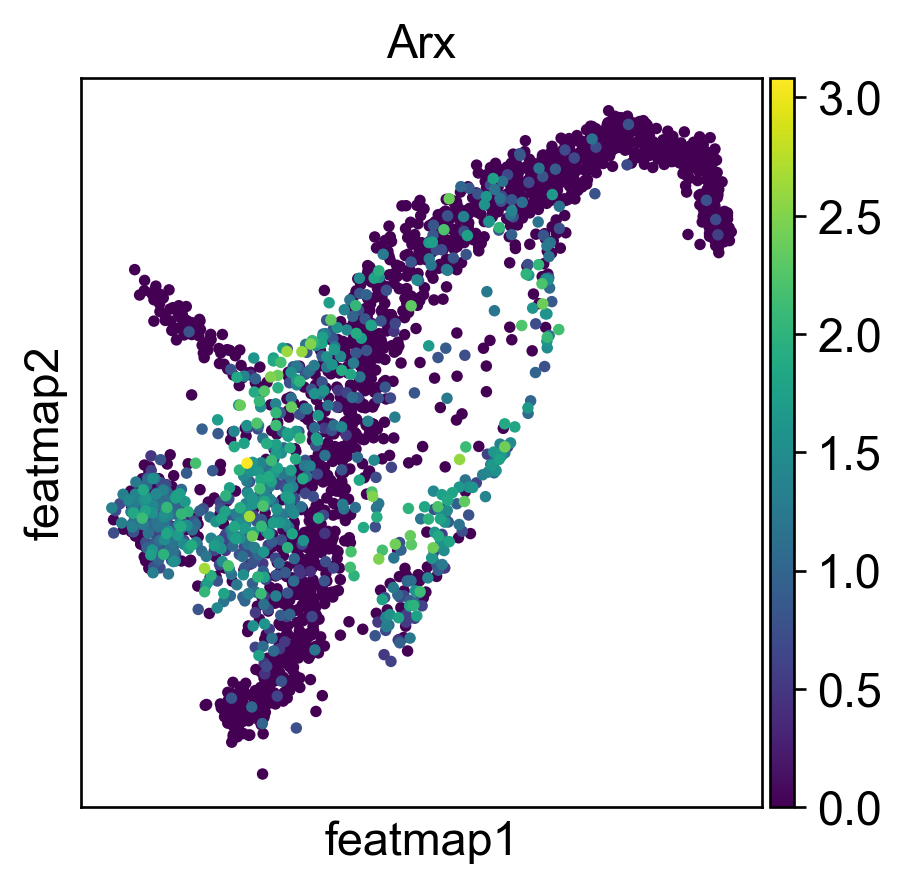

Rank of Arx is  [7] in transition_1
Start matrix multiplication
Finish matrix multiplication in 0.014462947845458984


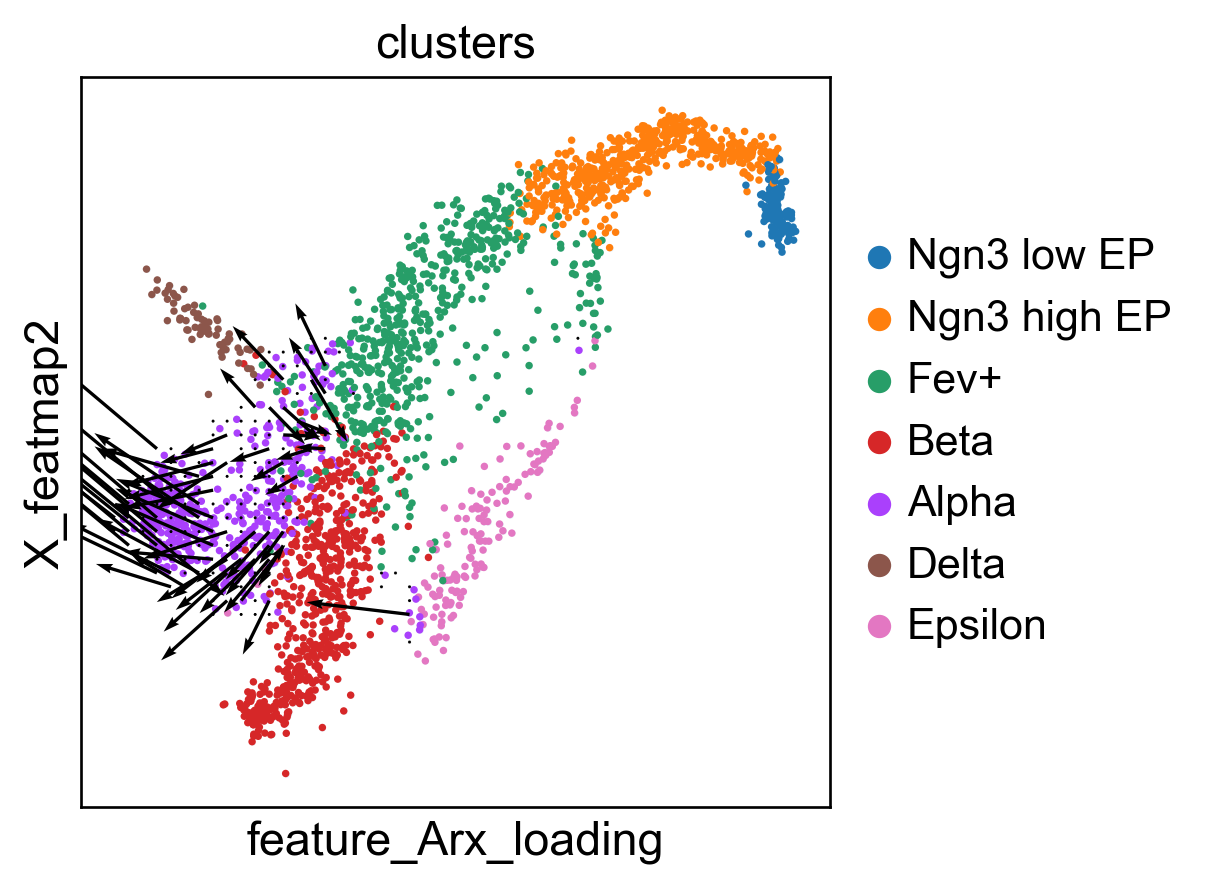

<Figure size 480x480 with 0 Axes>

In [28]:

sc.tl.rank_genes_groups(adata_var, 'core_trans_states_bifur', groups=['transition_1'],  method='wilcoxon', use_raw=False, layer='var_filter')
sc.pl.rank_genes_groups(adata_var, n_genes=25, sharey=False)
# Top 5 genes in rank_genes_groups
top_genes = adata_var.uns['rank_genes_groups']['names']['transition_1'][:5]


gene = 'Arx'
sc.pl.embedding(adata, 'featmap' ,color=[gene],)
rank = np.where(adata_var.uns['rank_genes_groups']['names']['transition_1'] == gene)[0]
print(f'Rank of {gene} is  {rank} in transition_1')

features.feature_projection(adata, feature=gene)
features.plot_one_feature(adata, feature=gene, ratio=0.1, density=1, embedding='X_featmap',
                               pseudotime='feat_pseudotime', pseudotime_adjusted=True, 
                               plot_within_cluster=['Alpha']
                               )    


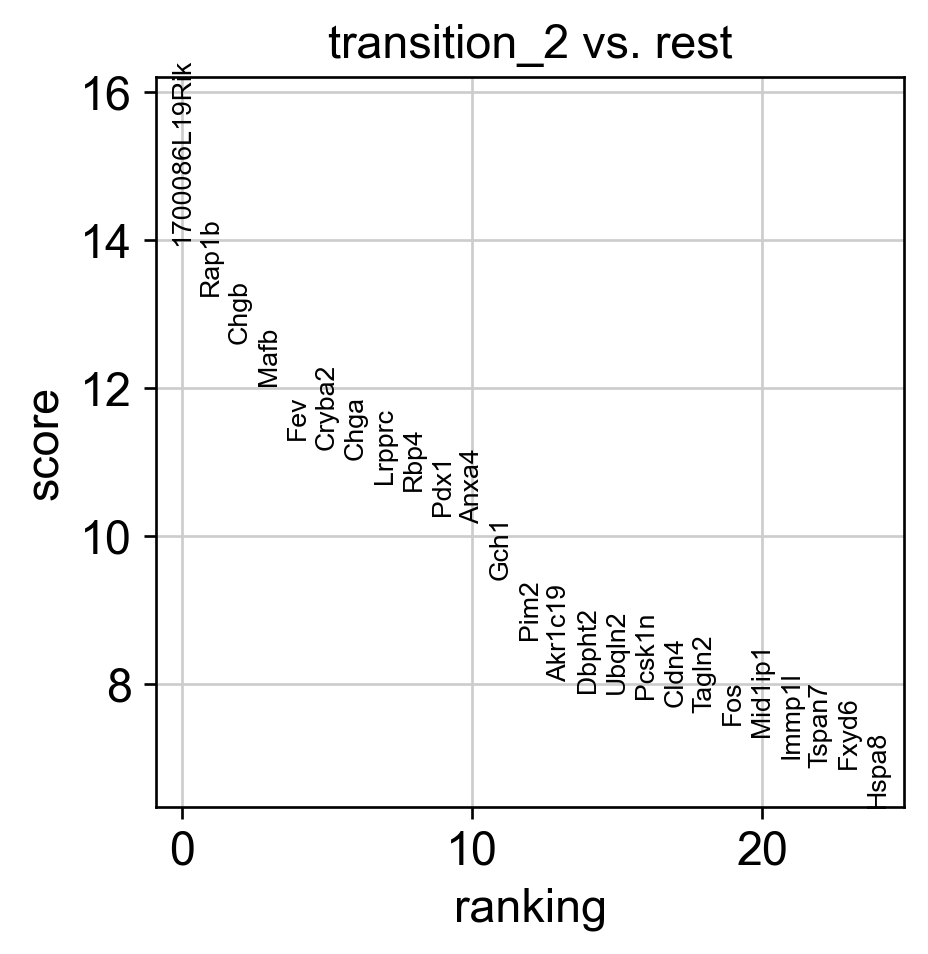

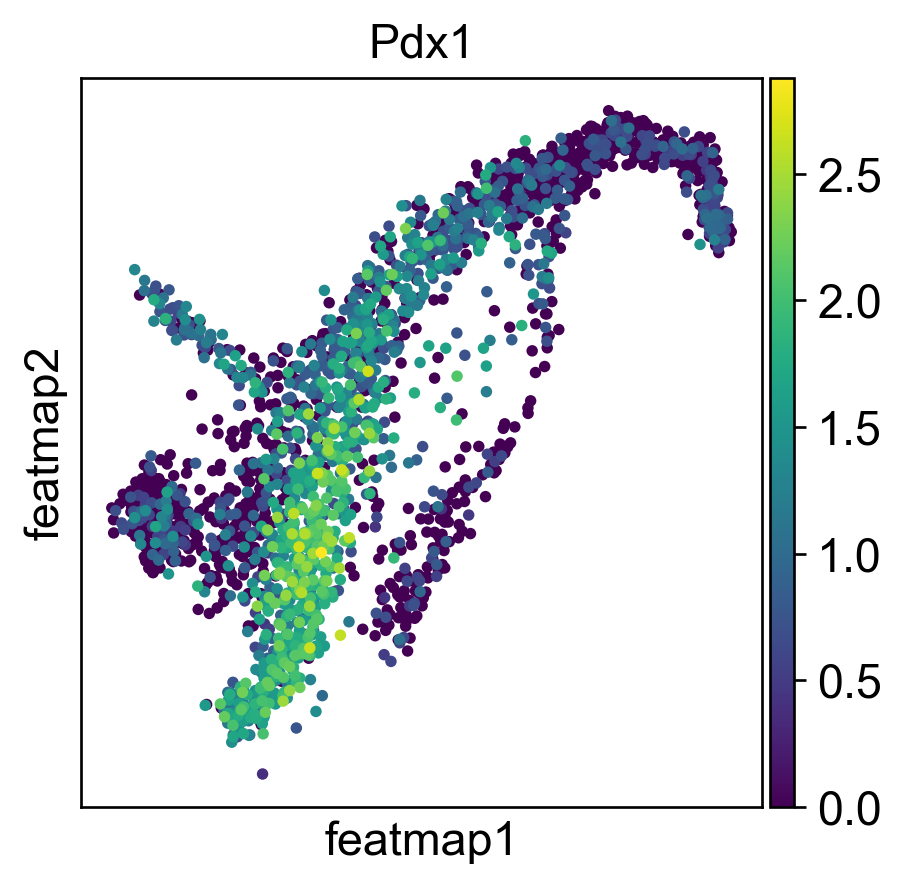

Rank of Pdx1 is  [9] in transition_2
Start matrix multiplication
Finish matrix multiplication in 0.013645172119140625


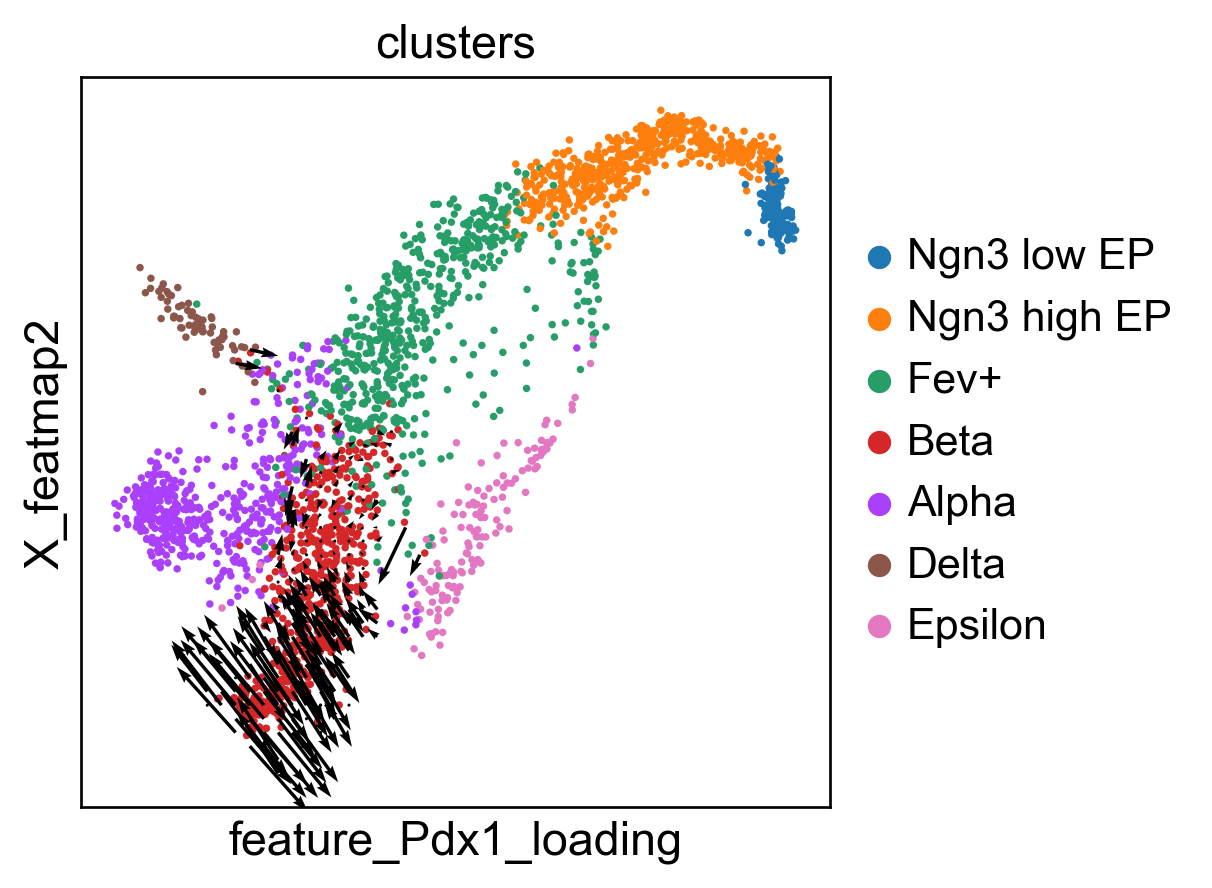

<Figure size 480x480 with 0 Axes>

In [29]:
sc.tl.rank_genes_groups(adata_var, 'core_trans_states_bifur', groups=['transition_2'],  method='wilcoxon', use_raw=False, layer='var_filter')
sc.pl.rank_genes_groups(adata_var, n_genes=25, sharey=False)
# Top 5 genes in rank_genes_groups
top_genes = adata_var.uns['rank_genes_groups']['names']['transition_2'][:5]

gene = 'Pdx1'
sc.pl.embedding(adata, 'featmap' ,color=[gene],)
rank = np.where(adata_var.uns['rank_genes_groups']['names']['transition_2'] == gene)[0]
print(f'Rank of {gene} is  {rank} in transition_2')

features.feature_projection(adata, feature=gene)
features.plot_one_feature(adata, feature=gene, ratio=0.1, density=1, embedding='X_featmap',
                               pseudotime='feat_pseudotime', pseudotime_adjusted=False, 
                               plot_within_cluster=['Beta',]
                               )    



In [30]:
adata


AnnData object with n_obs × n_vars = 2531 × 2000
    obs: 'day', 'proliferation', 'G2M_score', 'S_score', 'phase', 'clusters_coarse', 'clusters', 'clusters_fine', 'louvain_Alpha', 'louvain_Beta', 'palantir_pseudotime', 'n_genes', 'feat_pseudotime', 'density', 'density_separate_cluster', 'corestates', 'corestates_largest', 'corestates_binary', 'corestates_points', 'core_trans_states', 'cell_variation', 'leiden_v', 'core_trans_states_bifur', 'path_states', 'intrinsic_dim'
    var: 'highly_variable_genes', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'clusters_colors', 'corestates_colors', 'core_trans_states_colors', 'leiden_v_colors', 'core_trans_states_bifur_colors', 'path_states_colors'
    obsm: 'X_featmap', '_knn_indices', 'U', 'Singular_value', 'VH', 'vh_smoothed', 'gauge_v1_emb', 'gauge_v2_emb', 'VH_embedding', 'R', 'mu_sum', 're_sum', 're_sum_without_log', 'emb_knn_indices', 'X_embedding', 'X_featmap_v', 'variation_pc', 'X_featmap_v_3d'
    var

In [31]:
# from featuremap import features

# import importlib
# importlib.reload(features)
# top_genes =  adata_var.uns['rank_genes_groups']['names']['transition'][:10]
# feature = top_genes
# for f in feature:
#     print(f'Plotting {f}...')
#     features.feature_projection(adata, feature=f)
#     features.plot_one_feature(adata, feature=f, ratio=0.1, density=1, embedding='X_featmap',
#                                pseudotime='feat_pseudotime', pseudotime_adjusted=False, 
#                             #    plot_within_cluster=['Delta', ]
#                                )    


In [32]:

# import importlib
# importlib.reload(features)

# features.plot_gauge_both(adata)